2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 4)

### Imports, Inits, and helper functions

In [1]:
jupyterNotebookEnabled = True
plotting = True
coursework, part = 4, 4
saving = True

if jupyterNotebookEnabled:
    %load_ext autoreload
    %autoreload 2

In [2]:
import sys
import os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [3]:
import pickle
import skopt
from skopt.plots import plot_convergence
import datetime
import time
import tensorflow as tf
import numpy as np
    
import matplotlib.pyplot as plt

from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer, trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts
    
from mylibs.dropout_helper import constructProbs

from skopt.space.space import Real, Integer
from skopt import gp_minimize

from mylibs.jupyter_notebook_helper import show_graph

from mlp.data_providers import DataProvider, \
    MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
    
from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg, fully_connected_layer_with_batch_norm

from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2

from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats, renderStatsCollection
    
from rnn.manual_rnn import ManualRNN
from collections import OrderedDict

In [4]:
if jupyterNotebookEnabled:
    %matplotlib inline

seed = 16011984
rng = np.random.RandomState(seed=seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

figcount = 0

tensorboardLogdir = 'tf_cw%d_%d' % (coursework, part)

curDtype = tf.float32

reluBias = 0.1

batch_size = 50
#numTestSongs = 9950
numClasses = 10

segment_count = 120
segment_len = 25

In [5]:
#http://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
def loadPythonVarOrSave(filename, lambda_var):
    if os.path.isfile(filename):
        with open(filename) as f:  # Python 3: open(..., 'rb')
            (thevar, ) = pickle.load(f)
    else:
        thevar = lambda_var()
        with open(filename, 'w') as f:  # Python 3: open(..., 'wb')
            pickle.dump([thevar], f)
            
    return thevar

In [6]:
best_params_filename = 'best_params_rnn.npy'

In [7]:
from mylibs.jupyter_notebook_helper import DynStats

### MSD 10 genre task

In [8]:
best_params = np.load(best_params_filename)
state_size, num_steps = best_params
best_params

array([341,   4])

In [9]:
def onTrainEnd(stats, logits_dict):
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, DynStats.keys)
        plt.show()

In [10]:
logits_filename = 'rnn_logits.npy'
stats_list_filename = 'rnn_stats_list_cross_validate.npy'

In [11]:
if jupyterNotebookEnabled:
    %%time

if os.path.isfile(logits_filename):
    logits = np.load(logits_filename)
    stats_list = np.load(stats_list_filename)
else:
    manualRNN = ManualRNN(batch_size=batch_size,rng=rng, dtype=curDtype, config=config,
                          segment_count = segment_count, segment_len=segment_len, seed=seed)

    stats_list, logits_arr = manualRNN.cross_gather_logits(
        n_splits=10,
        epochs=30,
        state_size = state_size,
        num_steps=num_steps,
        onTrainEnd=onTrainEnd
    )

    np.save('rnn_logits.npy', logits_arr)
    np.save('rnn_stats_list_cross_validate.npy', stats_list)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [12]:
keys = [(s,) for s in range(len(stats_list))]
stats_dict = OrderedDict(zip(keys, stats_list))

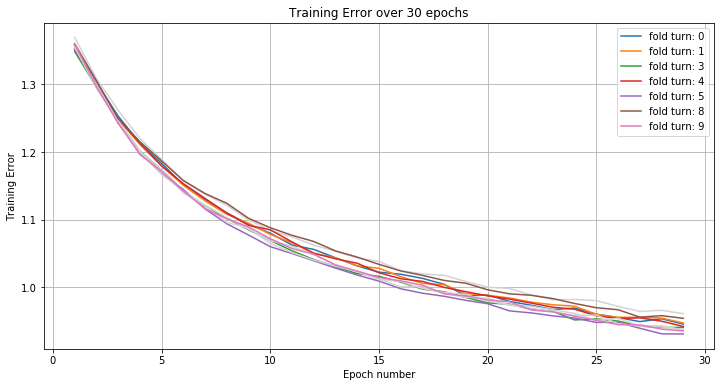

In [14]:
key = 'error(train)'
fig = renderStatsCollection(k=key, title='Training Error',
                            label_texts=['fold turn'],
                            statsCollection=stats_dict, epochs = 30)
if saving:
    fig.savefig('cw{}_part{}_fig_{}.svg'.format(coursework, part, key))

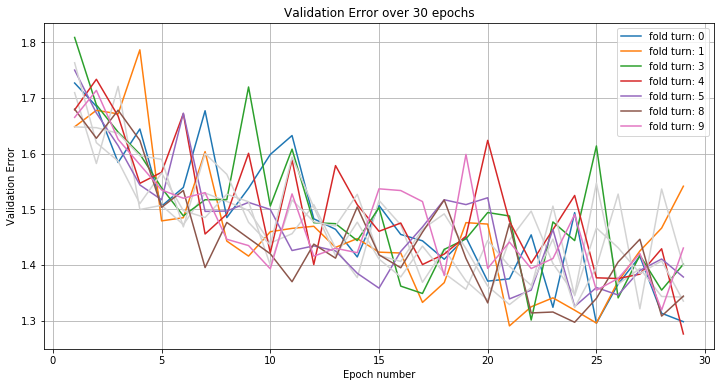

In [17]:
key = 'error(valid)'
fig = renderStatsCollection(k=key, title='Validation Error',
                            label_texts=['fold turn'],
                            statsCollection=stats_dict, epochs = 30)
if saving:
    fig.savefig('cw{}_part{}_fig_{}.svg'.format(coursework, part, key))

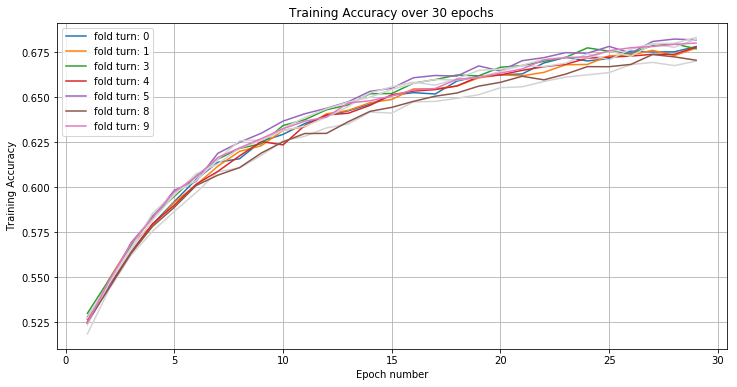

In [16]:
key = 'acc(train)'
fig = renderStatsCollection(k=key, title='Training Accuracy',
                            label_texts=['fold turn'],
                            statsCollection=stats_dict, epochs = 30)
if saving:
    fig.savefig('cw{}_part{}_fig_{}.svg'.format(coursework, part, key))

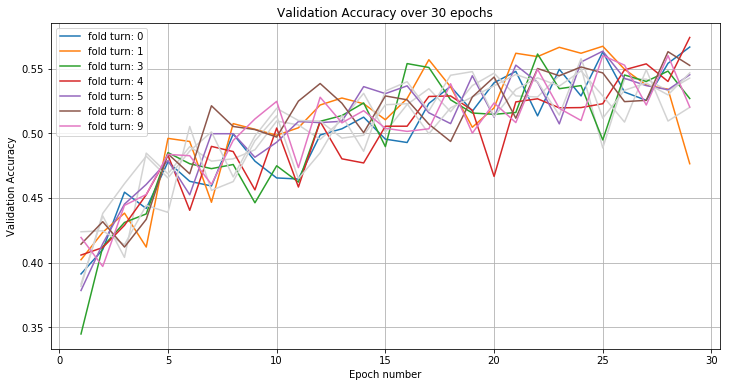

In [18]:
key = 'acc(valid)'
fig = renderStatsCollection(k=key, title='Validation Accuracy',
                            label_texts=['fold turn'],
                            statsCollection=stats_dict, epochs = 30)
if saving:
    fig.savefig('cw{}_part{}_fig_{}.svg'.format(coursework, part, key))

mean maximums

In [22]:
DynStats.keys

{'acc(train)': 1, 'acc(valid)': 3, 'error(train)': 0, 'error(valid)': 2}

In [24]:
np.mean([np.max(stats[:, 0]) for stats in stats_list])

1.4520172359877161

In [25]:
np.mean([np.max(stats[:, 1]) for stats in stats_list])

0.67833331695199006

In [26]:
np.mean([np.max(stats[:, 2]) for stats in stats_list])

1.8425632933378222

In [27]:
np.mean([np.max(stats[:, 3]) for stats in stats_list])

0.56127998206019414

In [30]:
max_accs = [np.max(stats[:, 3]) for stats in stats_list]
max_accs

[0.5665999829769135,
 0.56719998449087139,
 0.55079997748136522,
 0.56119997769594188,
 0.57399998307228084,
 0.56339998513460154,
 0.54899998068809508,
 0.55759998381137843,
 0.56299998193979262,
 0.55999998331069945]

In [36]:
mean_val = np.mean(max_accs)
mean_val

0.56127998206019414

In [37]:
min_val = np.min(max_accs)
min_val

0.54899998068809508

In [38]:
max_val = np.max(max_accs)
max_val

0.57399998307228084

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


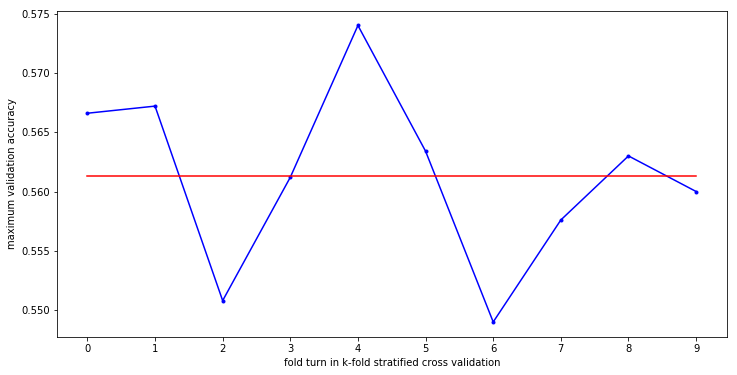

In [35]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.hold(True)
    xvals = np.arange(len(max_accs))
    plt.plot(xvals, max_accs,'b.-')
    plt.plot(xvals, np.repeat(mean_val, len(max_accs)),'r-')
    plt.hold(False)
    plt.xticks(xvals)
    plt.xlabel('fold turn in k-fold stratified cross validation')
    plt.ylabel('maximum validation accuracy')
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_max_accs.svg'.format(coursework, part))

## TESTING

In [101]:
feed = np.arange(10) + 10
feed

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [102]:
#initial = np.array([3, 0, 2, 1])
initial = np.random.permutation(feed)
initial

array([16, 19, 10, 17, 14, 12, 11, 15, 18, 13])

In [103]:
cur = np.array(initial)
cur

array([16, 19, 10, 17, 14, 12, 11, 15, 18, 13])

In [104]:
cur = np.random.permutation(cur)
cur = np.random.permutation(cur)
cur

array([12, 15, 16, 13, 19, 14, 10, 11, 18, 17])

In [105]:
#inv_perm = initial[perm]
# inv_perm = np.argsort(cur)
# inv_perm

In [106]:
#perm[np.array([2, 3, 0, 1])]

In [107]:
initial_transposed = initial[np.newaxis].T
initial_transposed

array([[16],
       [19],
       [10],
       [17],
       [14],
       [12],
       [11],
       [15],
       [18],
       [13]])

In [108]:
matrix = np.argwhere(cur == initial_transposed)
matrix

array([[0, 2],
       [1, 4],
       [2, 6],
       [3, 9],
       [4, 5],
       [5, 0],
       [6, 7],
       [7, 1],
       [8, 8],
       [9, 3]])

In [109]:
inv_perm = matrix[:, 1]
inv_perm

array([2, 4, 6, 9, 5, 0, 7, 1, 8, 3])

In [110]:
np.all( cur[inv_perm] == initial )

True

In [100]:
len(initial.shape)

1

In [111]:
cur

array([12, 15, 16, 13, 19, 14, 10, 11, 18, 17])

In [112]:
test = np.zeros(20)
test

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [135]:
mydict = np.array([3,10,59,33,19,3,6,1,2,4])
#["a","b","c","d","e","f","g","h","i","j"]
#{12: "a", 15: "b", 16: "c", 13:"d", 19:"e", 14:"f", 10:"g", 11:"h", 18:"i", 17:"j"}
mydict

array([ 3, 10, 59, 33, 19,  3,  6,  1,  2,  4])

In [136]:
len(mydict) == len(cur)

True

In [137]:
test[cur] = mydict

In [138]:
test

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,
         1.,   3.,  33.,   3.,  10.,  59.,   4.,   2.,  19.])

In [117]:
cur < 15

array([ True, False, False,  True, False,  True,  True,  True, False, False], dtype=bool)

In [143]:
thedict = OrderedDict(zip(cur, mydict))

In [145]:
test = np.zeros(20)
test[thedict.keys()] = thedict.values()
test

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,
         1.,   3.,  33.,   3.,  10.,  59.,   4.,   2.,  19.])